# Imports

In [34]:
import os
from pdf2image import convert_from_path, convert_from_bytes
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
import cv2 
import pytesseract
import numpy as np
from matplotlib import pyplot as plt
import re
import PyPDF2 as pyPdf
import time
import random
import ocrutils

# Fetch all PDF's of patents

In [2]:
#fetch all paths to pdf's
pdfs = []
for path, dirs, files in os.walk("/Volumes/Non-Backup_Files/GB-patents/"):
#     print(path)
    for f in files:
        if f.endswith('pdf'):
            pdfs.append('{}/{}'.format(path, f))

In [3]:
len(pdfs)

352736

In [4]:
pdfs[1]

'/Volumes/Non-Backup_Files/GB-patents/0/0/1/1/0/0/1/2/GB0110012A.pdf'

# OCR Functionality

In [23]:
def OCR_GB_patent(patent_pdf_path_index, patent_list):
    patent_str = ''
    patent_pdf_path = patent_list[patent_pdf_path_index]
    patent_name = patent_pdf_path.split('/')[-1][:-4]
    imgs = convert_from_path(patent_pdf_path)
    for img_index in range(len(imgs)):
        img = imgs[img_index]
        str_from_img = pytesseract.image_to_string(img)
        patent_str = '{}\n{}'.format(patent_str, str_from_img)
    with open('/Volumes/Non-Backup_Files/GB-patents/MachineReadableBaseline/{}.txt'.format(patent_name), "w") as text_file:
        text_file.write("%s" % patent_str)
        
def OCR_GB_patent_list(patent_list, timed=False):
    if not timed:
        for patent_pdf_path_index in range(len(patent_list)):
            OCR_GB_patent(patent_pdf_path_index, patent_list)
            if(patent_pdf_path_index % 1000 == 0):
                print('finished {}'.format(patent_pdf_path_index))
    else:
        times = []
        for patent_pdf_path_index in range(len(patent_list)):
            start = time.time()
            OCR_GB_patent(patent_pdf_path_index, patent_list)
            end = time.time()
            times.append(end - start)  
            if(patent_pdf_path_index % 1000 == 0):
                print('finished {}'.format(patent_pdf_path_index))
        return times

# OCR on small random sample to get an idea of complexity

In [24]:
test_list = random.sample(pdfs, 15)
times = OCR_GB_patent_list(test_list, timed=True)

finished 0


In [25]:
sum_times = 0
for i in times:
    sum_times += i
sum_times/len(times) * len(pdfs)

10028971.304937745

In [26]:
sum_times

426.4792070388794

In order to conduct OCR on all our documents, we would need two months. Let's try to cut that by using parallelism.

# Trying parallelism to do OCR

In [27]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


In [28]:
pool = mp.Pool(mp.cpu_count())

In [29]:
test_list = random.sample(pdfs, 15)
result_objects = [pool.apply_async(ocrutils.OCR_GB_patent, args=(i, test_list)) for i in range(len(test_list))]

In [30]:
start = time.time()
[r.get() for r in result_objects]
end = time.time()
delay = end - start

In [31]:
delay/len(test_list) * len(pdfs)

4518067.313246155

In [33]:
delay/len(test_list)

12.808636808395386

We cut the time in half with parallelism. We will have to use additional resources. Let's do our analysis on a random sample.

# Random Sample to get manageable subset

In [37]:
test_list = random.sample(pdfs, 2400)
result_objects = [pool.apply_async(ocrutils.OCR_GB_patent, args=(i, test_list)) for i in range(len(test_list))]

In [38]:
start = time.time()
[r.get() for r in result_objects]
end = time.time()
delay = end - start

KeyboardInterrupt: 

# SCRAP

In [ ]:
times = []

imgs_dict = {}
patents_w_imgs = []
test_list = random.sample(pdfs, 15)
# test_string = ''
# for patent_pdf_path_index in range(len(pdfs)):
# for patent_pdf_path_index in range(len(['/Volumes/Non-Backup_Files/GB-patents/Pre1900/1617/0-5000/GB161700001A.pdf'])):
for patent_pdf_path_index in range(len(test_list)):
# for patent_pdf_path in ['/Volumes/Non-Backup_Files/GB-patents/0/0/3/0/9/2/1/0/GB0309210A.pdf',
#                         '/Volumes/Non-Backup_Files/GB-patents/0/0/3/6/3/8/9/7/GB0363897A.pdf',
#                        '/Volumes/Non-Backup_Files/GB-patents/0/0/3/7/5/0/4/5/GB0375045A.pdf']:
    start = time.time()
    patent_str = ''
#     patent_pdf_path = pdfs[patent_pdf_path_index]
    patent_pdf_path = test_list[patent_pdf_path_index]
    patent_name = patent_pdf_path.split('/')[-1][:-4]
    
#     output_folder='/Volumes/Non-Backup_Files/GB-patents/Image_Format/{}'.format(patent_name)
#     mkdir(output_folder)
    imgs = convert_from_path(patent_pdf_path)
    imgs_dict.update({patent_name: imgs})
    for img_index in range(len(imgs)):
        img = imgs[img_index]
        str_from_img = pytesseract.image_to_string(img)
        patent_str = patent_str + '\n' + str_from_img
#         test_string = test_string + str_from_img
        if re.search('[Ff][Ii][Gg]\.[0-9]+', str_from_img) or re.search('[Ff][Ii][Gg]\. [0-9]+', str_from_img) or re.search('drawing', str_from_img):
            patents_w_imgs.append(patent_pdf_path)
            if img_index < len(imgs):
                for rest_img_index in range(img_index+1, len(imgs)):
                    str_from_img = pytesseract.image_to_string(img)
                    patent_str = patent_str + '\n' + str_from_img
            break
    with open('/Volumes/Non-Backup_Files/GB-patents/MachineReadableBaseline/{}.txt'.format(patent_name), "w") as text_file:
        text_file.write("%s" % patent_str)
    end = time.time()
    times.append(end - start)    
    if(patent_pdf_path_index % 1000 == 0):
        print('finished {}'.format(patent_pdf_path_index))
        
# write_list(patents_w_imgs, 'patents_with_images_list.txt')

In [13]:
# RUN TO GET ALL PATENTS TO TXT FORMAT
imgs_dict = {}
patents_w_imgs = []

for patent_pdf_path_index in range(len(pdfs)):
    patent_str = ''
    patent_pdf_path = pdfs[patent_pdf_path_index]
    patent_name = patent_pdf_path.split('/')[-1][:-4]
    imgs = convert_from_path(patent_pdf_path)
    imgs_dict.update({patent_name: imgs})
    for img_index in range(len(imgs)):
        img = imgs[img_index]
        str_from_img = pytesseract.image_to_string(img)
        patent_str = patent_str + '\n' + str_from_img
        if re.search('[Ff][Ii][Gg]\.[0-9]+', str_from_img) or re.search('[Ff][Ii][Gg]\. [0-9]+', str_from_img) or re.search('drawing', str_from_img):
            patents_w_imgs.append(patent_pdf_path)
            if img_index < len(imgs):
                for rest_img_index in range(img_index+1, len(imgs)):
                    str_from_img = pytesseract.image_to_string(img)
                    patent_str = patent_str + '\n' + str_from_img
            break
    with open('/Volumes/Non-Backup_Files/GB-patents/MachineReadableBaseline/{}.txt'.format(patent_name), "w") as text_file:
        text_file.write("%s" % patent_str)
        
    if(patent_pdf_path_index % 1000 == 0):
        print('finished {}'.format(patent_pdf_path_index))
        
write_list(patents_w_imgs, 'patents_with_images_list.txt')

finished 0
37.15609693527222


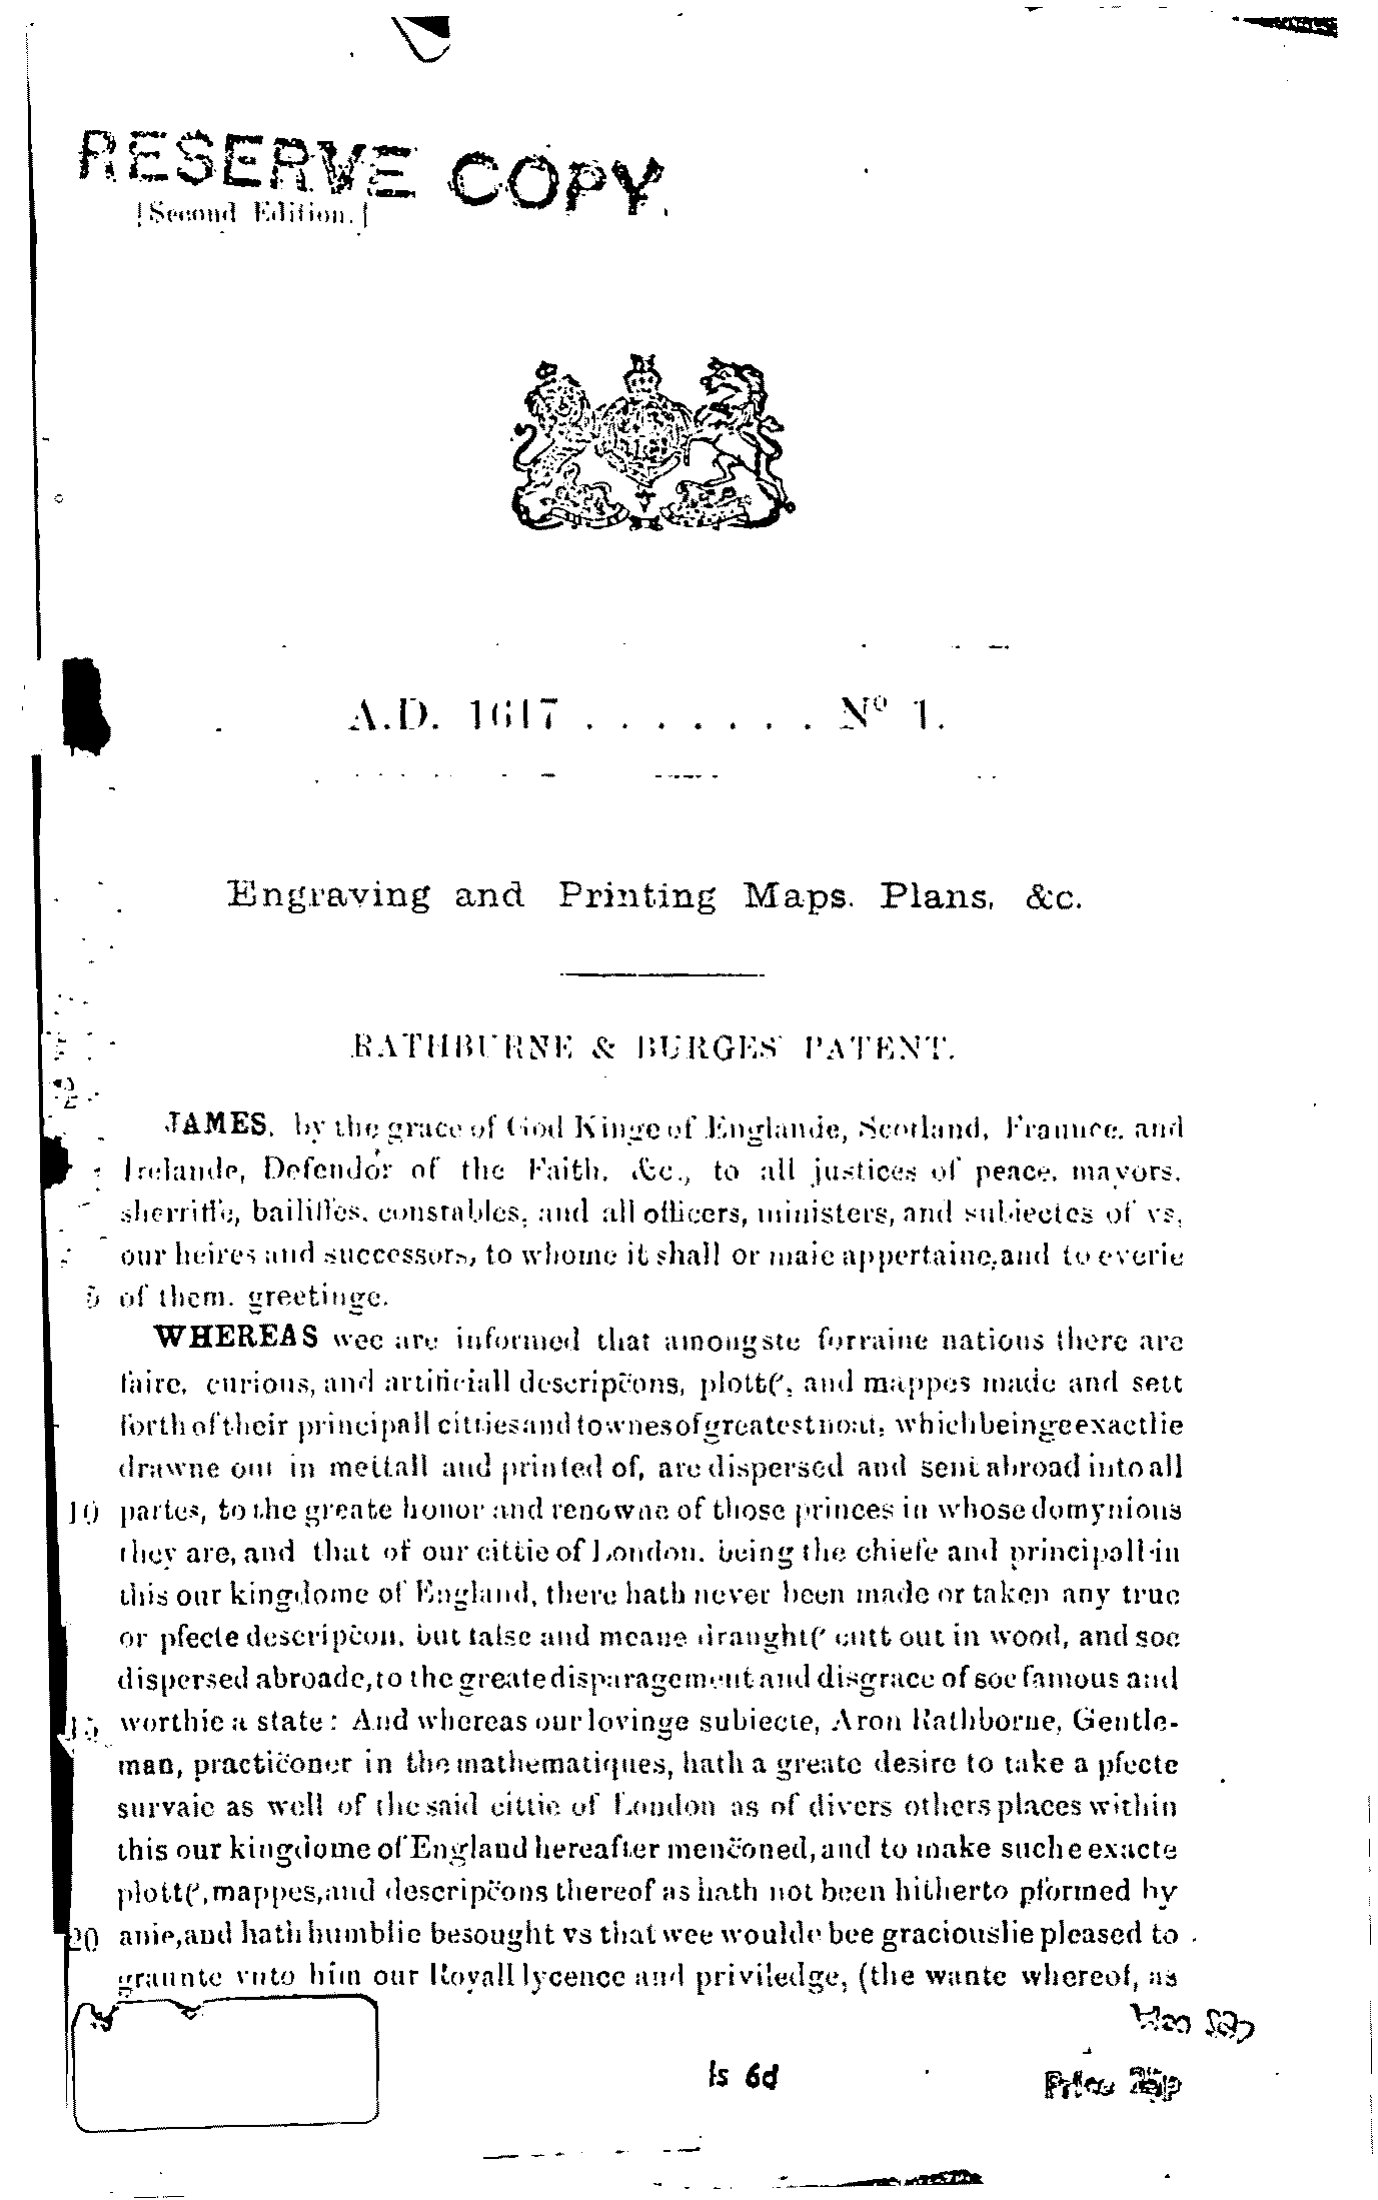

In [5]:
imgs_dict['GB161700001A'][0]

In [ ]:
import time
import random
times = []

imgs_dict = {}
patents_w_imgs = []
test_list = random.sample(pdfs, 15)
# test_string = ''
# for patent_pdf_path_index in range(len(pdfs)):
# for patent_pdf_path_index in range(len(['/Volumes/Non-Backup_Files/GB-patents/Pre1900/1617/0-5000/GB161700001A.pdf'])):
for patent_pdf_path_index in range(len(test_list)):
# for patent_pdf_path in ['/Volumes/Non-Backup_Files/GB-patents/0/0/3/0/9/2/1/0/GB0309210A.pdf',
#                         '/Volumes/Non-Backup_Files/GB-patents/0/0/3/6/3/8/9/7/GB0363897A.pdf',
#                        '/Volumes/Non-Backup_Files/GB-patents/0/0/3/7/5/0/4/5/GB0375045A.pdf']:
    start = time.time()
    patent_str = ''
#     patent_pdf_path = pdfs[patent_pdf_path_index]
    patent_pdf_path = test_list[patent_pdf_path_index]
    patent_name = patent_pdf_path.split('/')[-1][:-4]
    
#     output_folder='/Volumes/Non-Backup_Files/GB-patents/Image_Format/{}'.format(patent_name)
#     mkdir(output_folder)
    imgs = convert_from_path(patent_pdf_path)
    imgs_dict.update({patent_name: imgs})
    for img_index in range(len(imgs)):
        img = imgs[img_index]
        str_from_img = pytesseract.image_to_string(img)
        patent_str = patent_str + '\n' + str_from_img
#         test_string = test_string + str_from_img
        if re.search('[Ff][Ii][Gg]\.[0-9]+', str_from_img) or re.search('[Ff][Ii][Gg]\. [0-9]+', str_from_img) or re.search('drawing', str_from_img):
            patents_w_imgs.append(patent_pdf_path)
            if img_index < len(imgs):
                for rest_img_index in range(img_index+1, len(imgs)):
                    str_from_img = pytesseract.image_to_string(img)
                    patent_str = patent_str + '\n' + str_from_img
            break
    with open('/Volumes/Non-Backup_Files/GB-patents/MachineReadableBaseline/{}.txt'.format(patent_name), "w") as text_file:
        text_file.write("%s" % patent_str)
    end = time.time()
    times.append(end - start)    
    if(patent_pdf_path_index % 1000 == 0):
        print('finished {}'.format(patent_pdf_path_index))
        
# write_list(patents_w_imgs, 'patents_with_images_list.txt')

In [43]:
img = np.array(imgs_dict['GB161700001A'][0])

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)


In [40]:
# plt.imshow(canny(img))
# plt.show()

# plt.figure(figsize=(18,18))
# plt.imshow(dilate(canny(img)))
# plt.axis('off')
# plt.show()

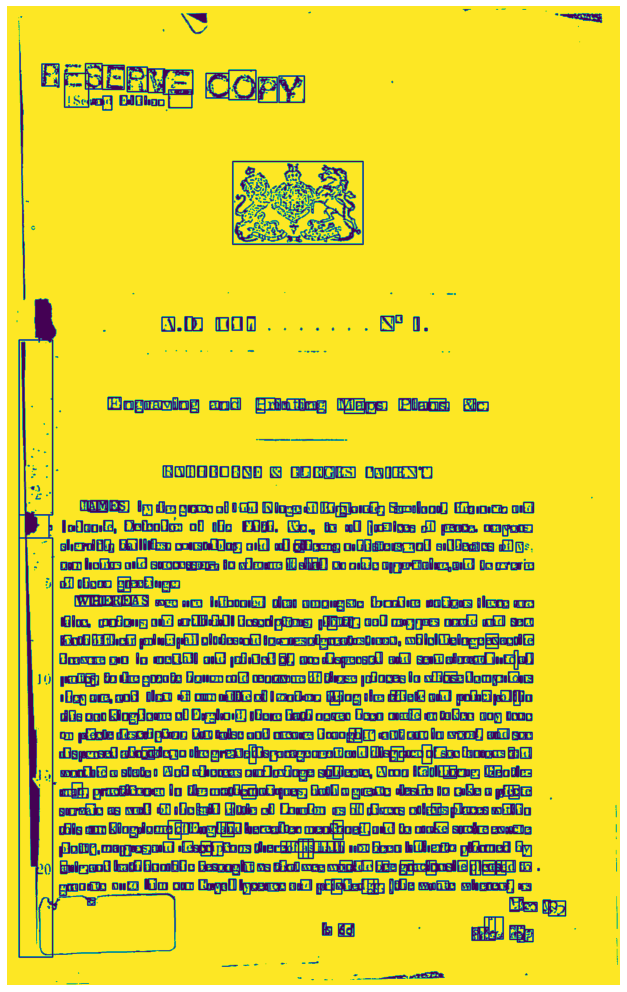

In [41]:
img = get_grayscale(img)
h, w = img.shape
boxes = pytesseract.image_to_boxes(img) 
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

plt.figure(figsize=(18,18))
plt.imshow(img)
plt.axis('off')
plt.show()

In [57]:
import re
if re.search('[Ff][Ii][Gg]\.[0-9]+', pytesseract.image_to_string(img)):
    print('l')

In [60]:
for i in range(10):
    for j in range(5):
        if j == 3:
            break
        print(i,j)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2
5 0
5 1
5 2
6 0
6 1
6 2
7 0
7 1
7 2
8 0
8 1
8 2
9 0
9 1
9 2
